In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os

In [2]:
#variables to modify
n_sensors = 21
time_header = "timestamp" #header of the timestamp column
folder_name = 'level1_airassure_data'
first_timestamp = "2023-12-18 00:00:00"
last_timestamp = "2023-12-31 23:45:00" #--fill data if there are missing values between these timestamps
parameters = ["pm1", "pm2.5", "pm4", "pm10", "co2", "tvoc"] #set the parameter you want to harmonize; 
#the parameter name should be exactly the same as in the headers in the csv files, written in a list, ex. ["PM 2.5", "PM 1.0", "CO2"]

In [11]:
#read data
data = []
data = [pd.read_csv(f'{folder_name}/A' + str(i+1) + '.csv') for i in range(n_sensors)]
sensor_names = [f'A{i+1}' for i in range(n_sensors)]

print("checking the lengths of the sensor data:")
u = [len(data[i].index) for i in range(n_sensors)]
print(u)

#---------------------------------------
#convert the timestamps to datetime type
for i in range(n_sensors):
    data[i][time_header] = pd.to_datetime(data[i][time_header])

#set the timestamps as index
start = pd.to_datetime(first_timestamp)
end = pd.to_datetime(last_timestamp)
dates = pd.date_range(start=start, end=end, freq='15Min')

#fill the missing values with nan
data = [data[i].set_index(time_header).reindex(dates).reset_index() for i in range(n_sensors)]

#create a folder to save results of harmonization
result_folder = 'harmonization_results'
level2_folder = 'level2_data'
if not os.path.isdir(result_folder):
    os.makedirs(f'./{result_folder}/{level2_folder}')


checking the lengths of the sensor data:
[1344, 1344, 1344, 1344, 1344, 1344, 1344, 1344, 1344, 1344, 1344, 1344, 1344, 1344, 1344, 1344, 1344, 1344, 1344, 1344, 1344]


In [6]:
def harmonize(parameter):

    #finding the median values for each timestamp - 'parameter_data' is 2-dimensional arrays to store the values of the parameter for all sensors
    parameter_data = [data[i][parameter].values for i in range(n_sensors)]

    #cut off sensors with missing days to find the median in a simpler way
    parameter_data = np.array([parameter_data[i] for i in range(n_sensors)])
    median = np.nanmedian(parameter_data, axis=0)

    #-------------------------------------------------
    #for plotting
    plt_columns = n_sensors//5+1
    figure, axis = plt.subplots(5, plt_columns)

    #for regression
    def func(x, a, b):
        return a*x + b

    #to save calibration factors
    calibration_factors = np.zeros(n_sensors)
    #to save harmonized data
    harmonized_data = np.zeros((n_sensors, len(median)))
    r2_values = np.zeros(n_sensors)

    x = median
    print(f'calculating harmonization data for {parameter} ...')
    for i in range(n_sensors):
        #plot the sensors' data against the median (the values are centralized to zero)
        axis[i//plt_columns, i%plt_columns].plot(median, data[i][parameter], 'o')
        axis[i//plt_columns, i%plt_columns].set_title(f"Sensor A{[i]}")
        axis[i//plt_columns, i%plt_columns].set_xlabel("median")

        #regression for slope
        y = data[i][parameter].values
        
        #to omit values with nan
        valid = ~ (np.isnan(x) | np.isnan(y))

        #regression (the values are centralized to zero, by setting the intercept to zero)
        popt, pcov = curve_fit(func, x[valid], y[valid], bounds=([-np.inf, -0.000001], [np.inf, 0.000001]))
        calibration_factors[i] = round(1/popt[0], 2)

        #r2 value
        residuals = y[valid] - func(x[valid], *popt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y[valid]-np.mean(y[valid]))**2)
        r_squared = 1 - (ss_res / ss_tot)
        r2_values[i] = r_squared.round(2)
        
        #plot the regression line
        axis[i//plt_columns, i%plt_columns].plot(x, func(x, *popt), 'r--')
        axis[i//plt_columns, i%plt_columns].text(0.1, 0.8, f"y={popt[0].round(2)}x", transform=axis[i//plt_columns, i%plt_columns].transAxes)
        axis[i//plt_columns, i%plt_columns].text(0.1, 0.7, f"r2={r_squared.round(2)}", transform=axis[i//plt_columns, i%plt_columns].transAxes)
        axis[i//plt_columns, i%plt_columns].axis('square')
    
    #to remove the empty plots
    for i in range(plt_columns*5-n_sensors):
        axis[-1, -(i+1)].axis('off')

    figure.set_size_inches(25, 16) #increase the plot's size
    figure.subplots_adjust(hspace=0.05, wspace=0.075, top=0.96) #reduce the space between plots
    
    plt.suptitle(f"{parameter} Harmonization", fontsize=16)
    plt.savefig(f'{result_folder}/{parameter}_harmonization_fitting.png', dpi=300)
    #plt.show()

    #
    #plots
    #plot the parameter vs time, truncating before 408
    plt.figure(figsize=(16,9))
    plt.plot(dates[:], median[:], label="median")
    for i in range(n_sensors):
        plt.plot(dates[:], data[i][parameter].iloc[:]*calibration_factors[i], label=f"sensor A{[i]}")

    #to save the harmonized data in a variable
    for i in range(n_sensors):
        harmonized_data[i][:] = data[i][parameter]*calibration_factors[i]

    #cosmetics of the plot
    plt.xlabel("Date", fontsize=16)
    plt.ylabel(parameter, fontsize=16)
    plt.legend(loc="upper right", fontsize=7)
    plt.title(f"{parameter} Harmonization", fontsize=16)
    plt.tight_layout()
    plt.savefig(f'{result_folder}/{parameter}_harmonization.png', dpi=300)
    #plt.show()

    return calibration_factors, harmonized_data, r2_values


calculating harmonization data for pm1 ...
calculating harmonization data for pm2.5 ...
calculating harmonization data for pm4 ...
calculating harmonization data for pm10 ...
calculating harmonization data for co2 ...
calculating harmonization data for tvoc ...


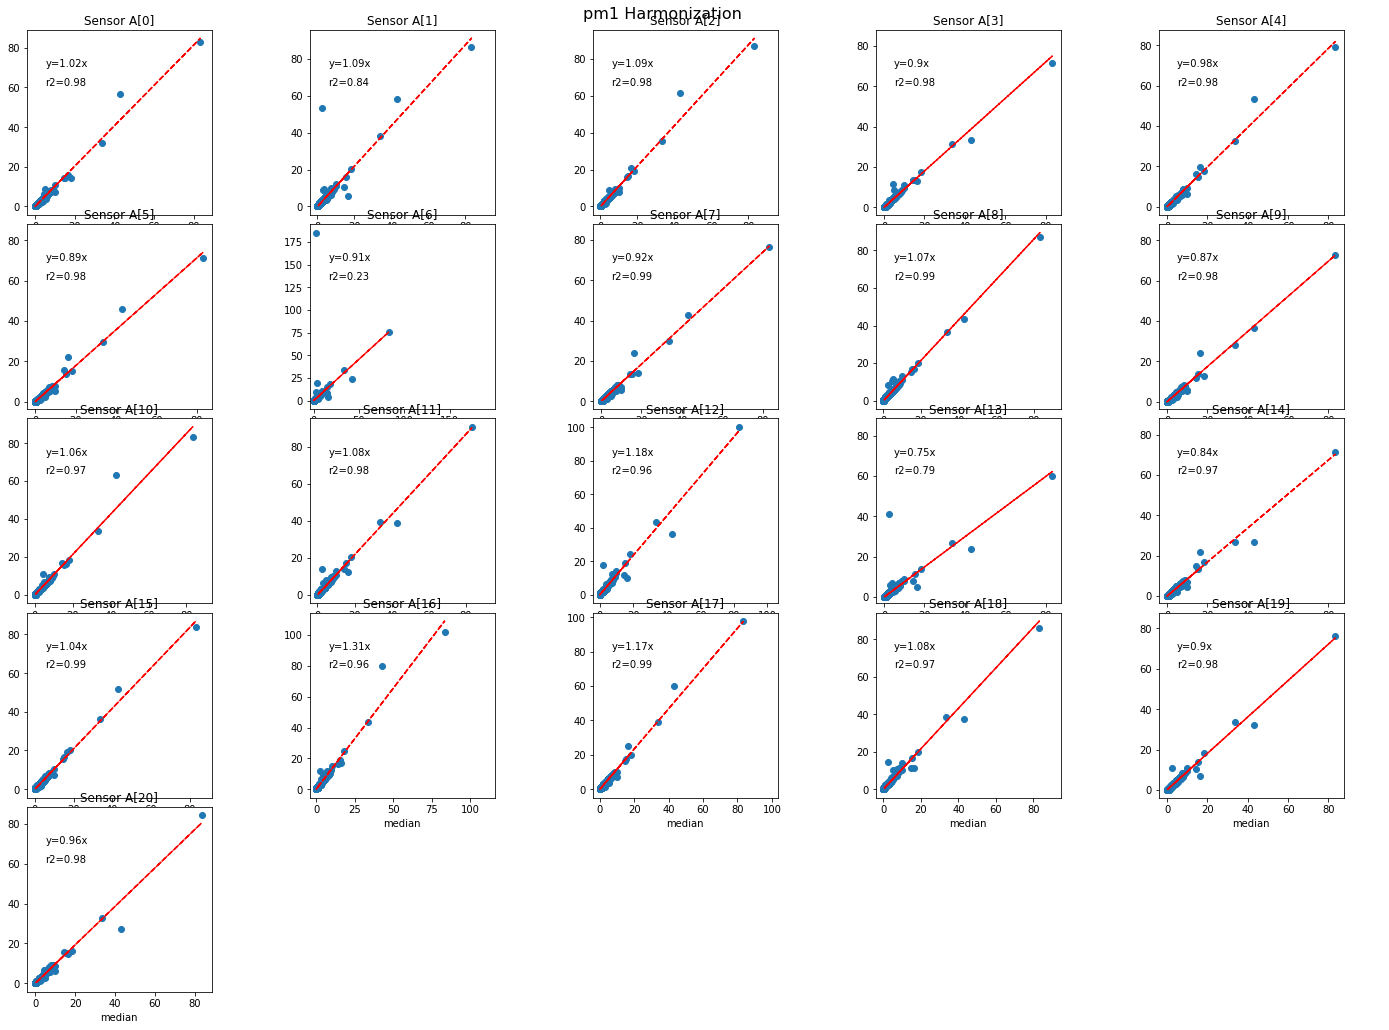

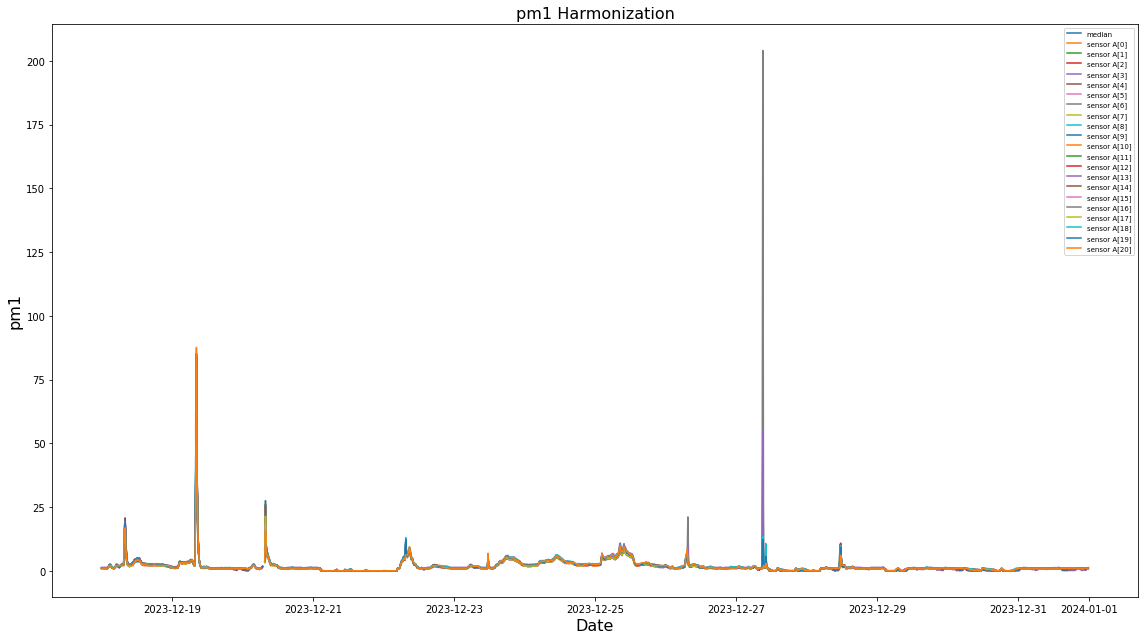

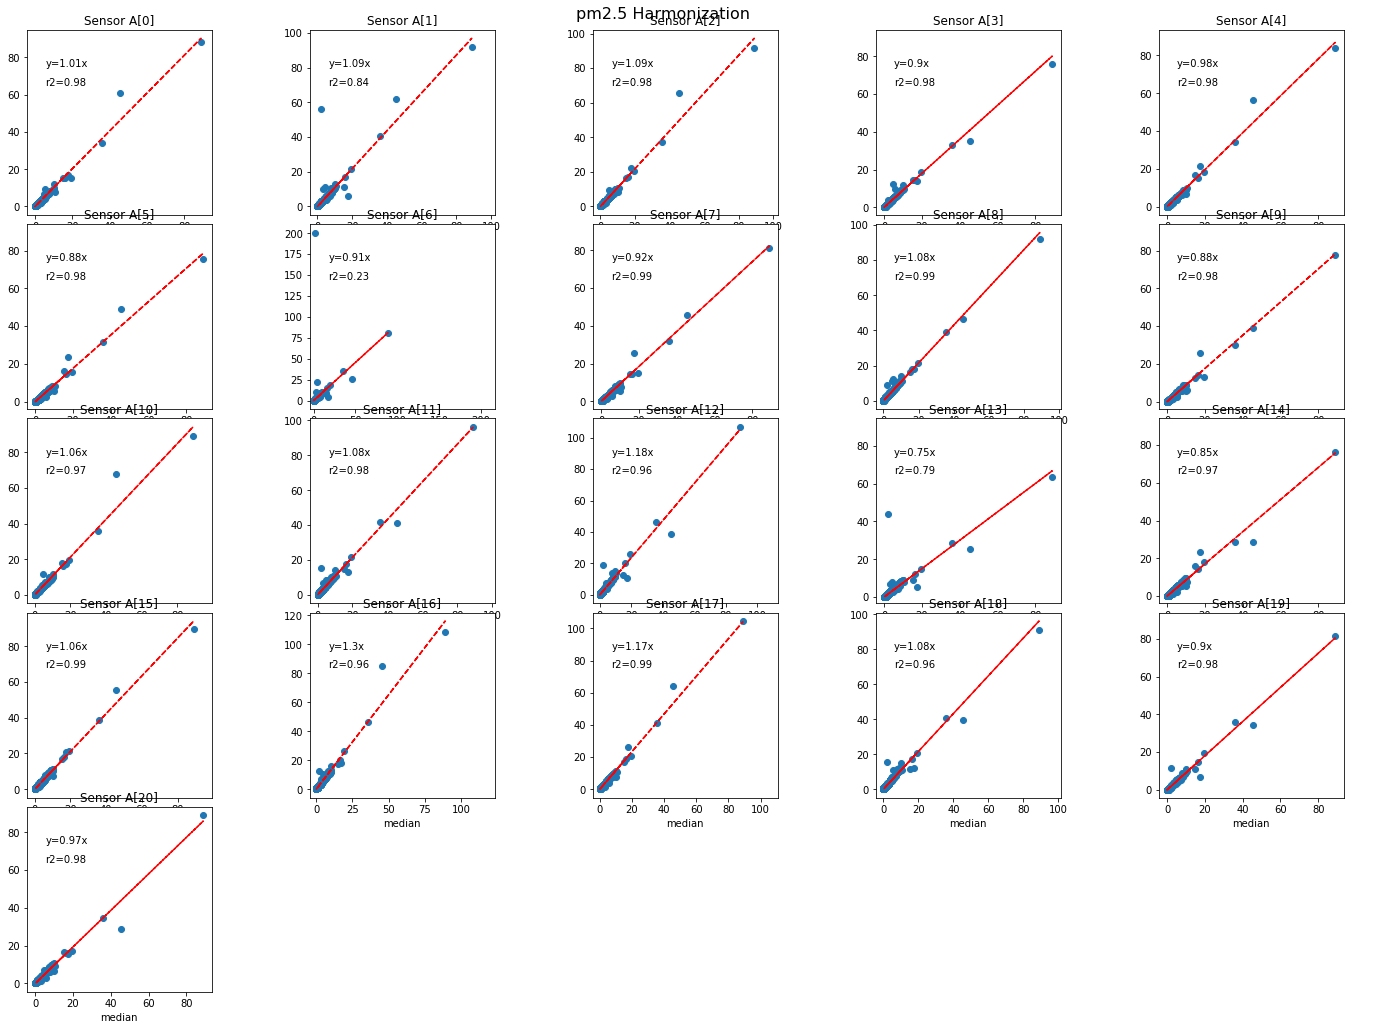

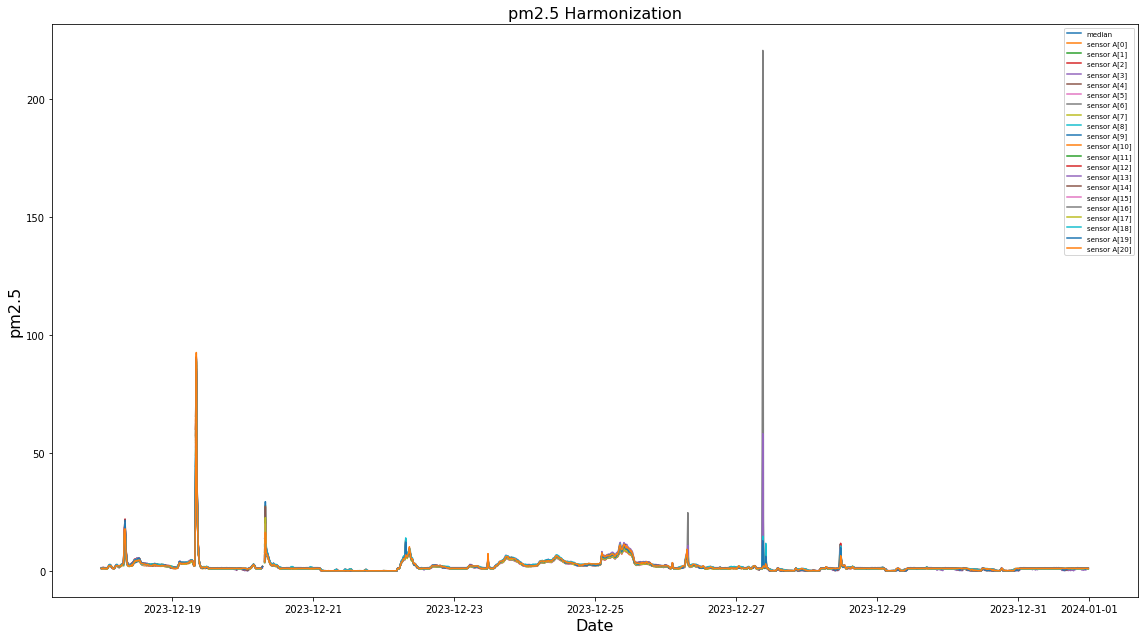

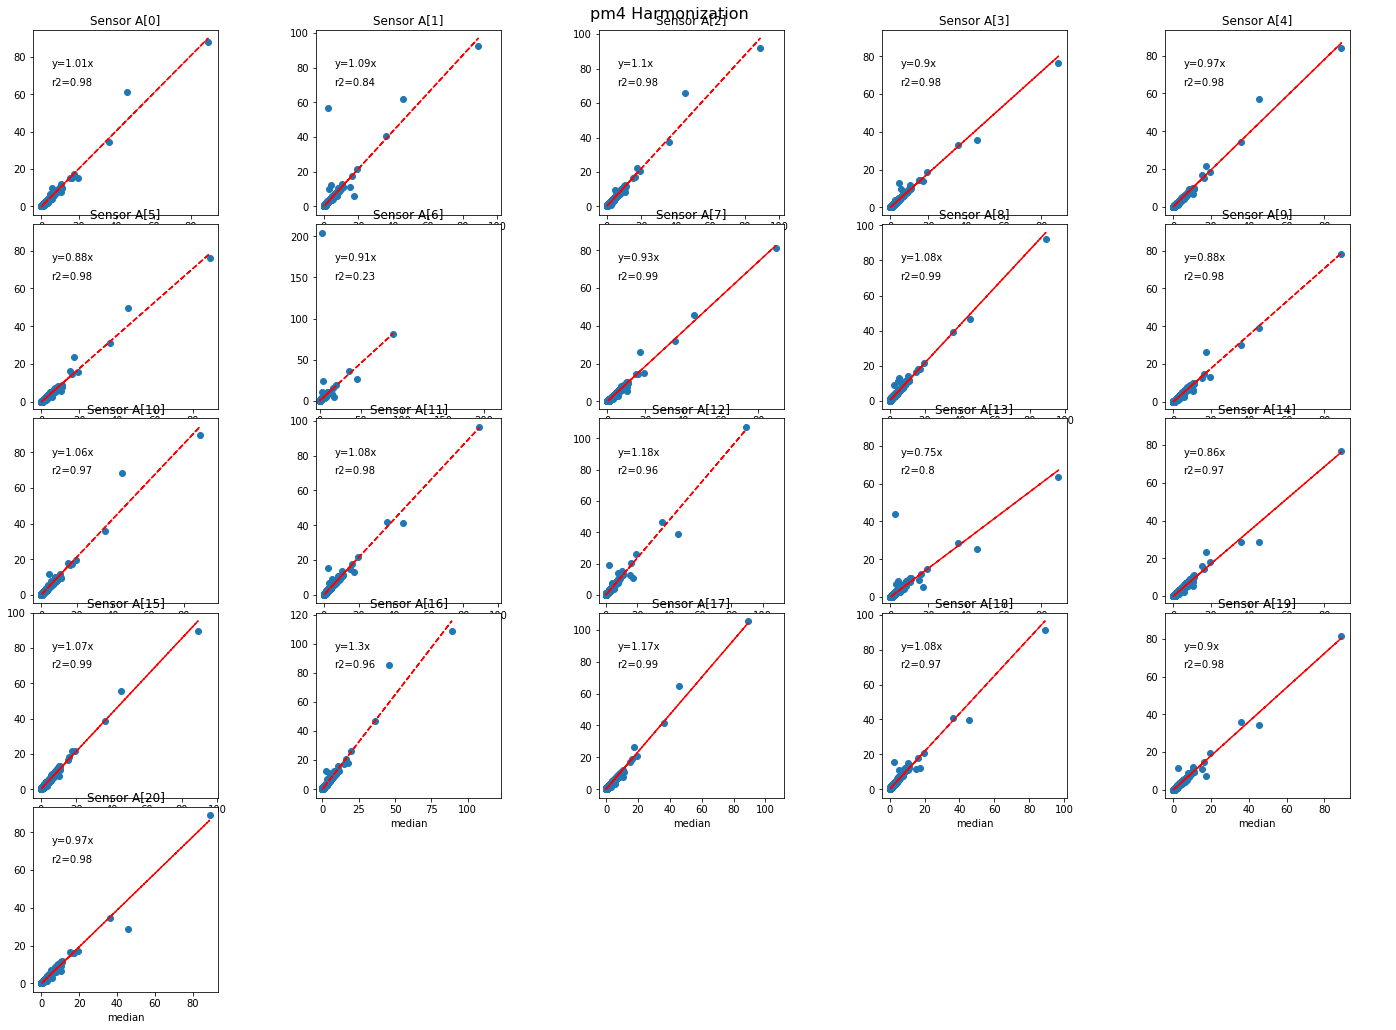

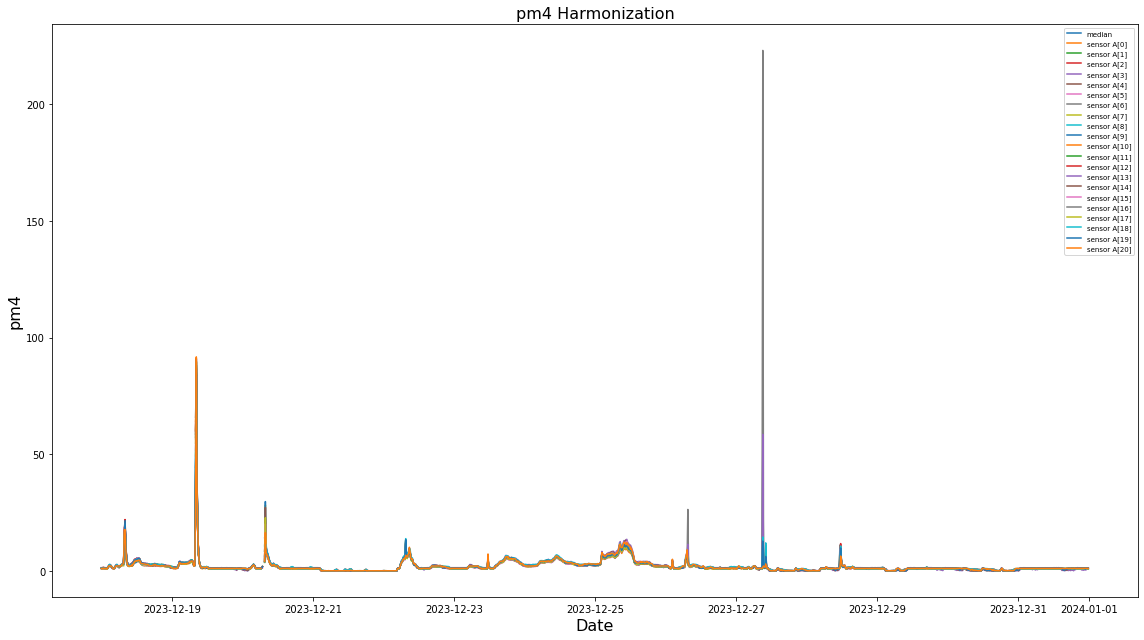

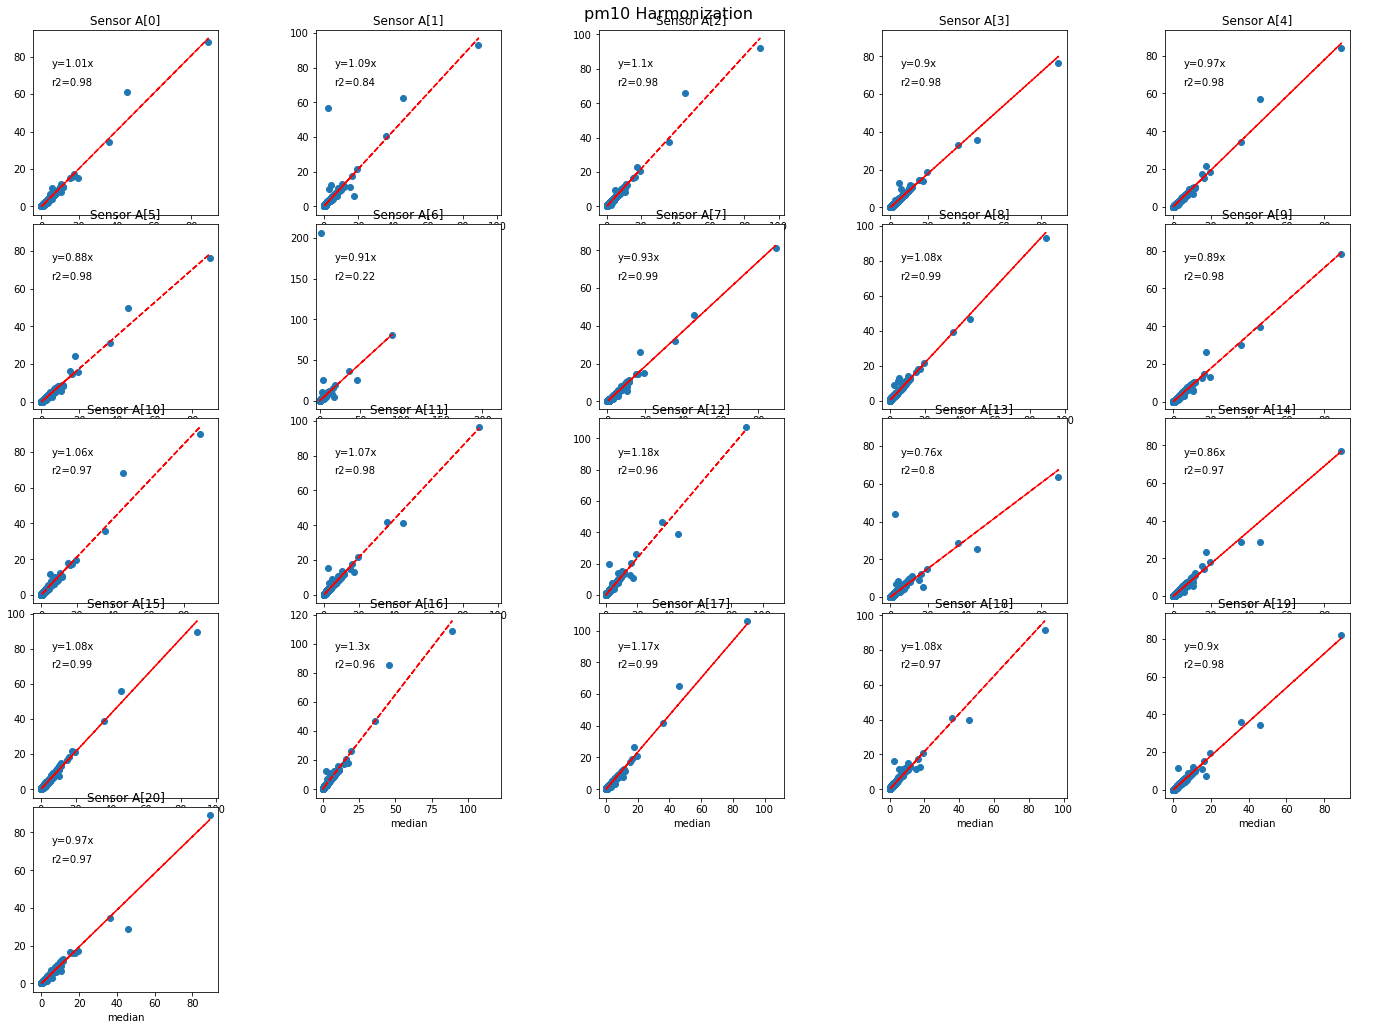

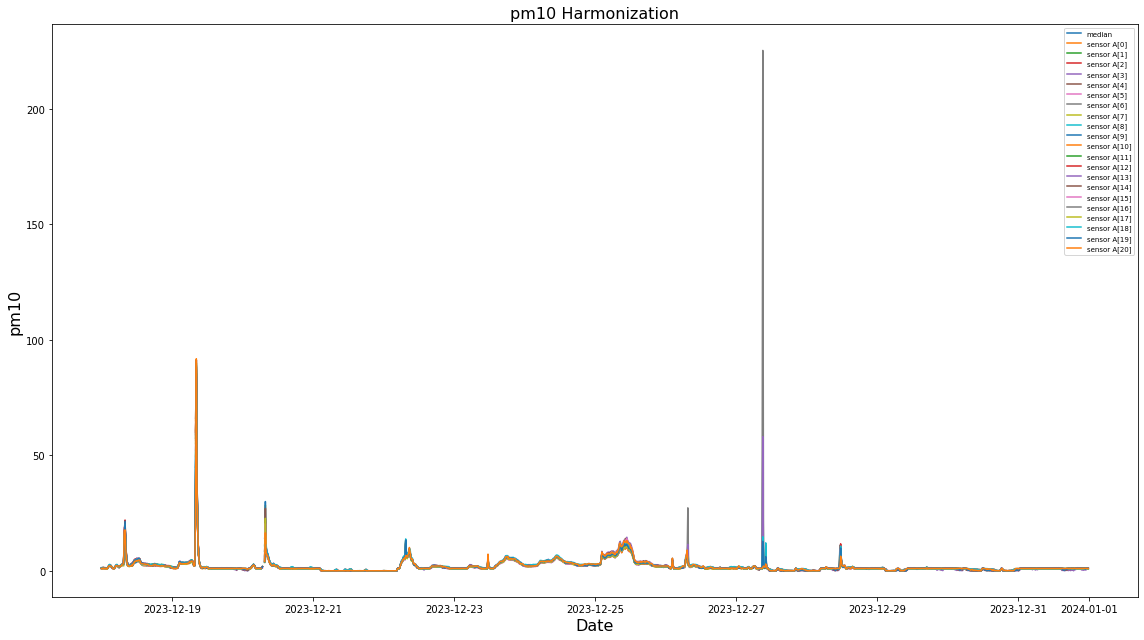

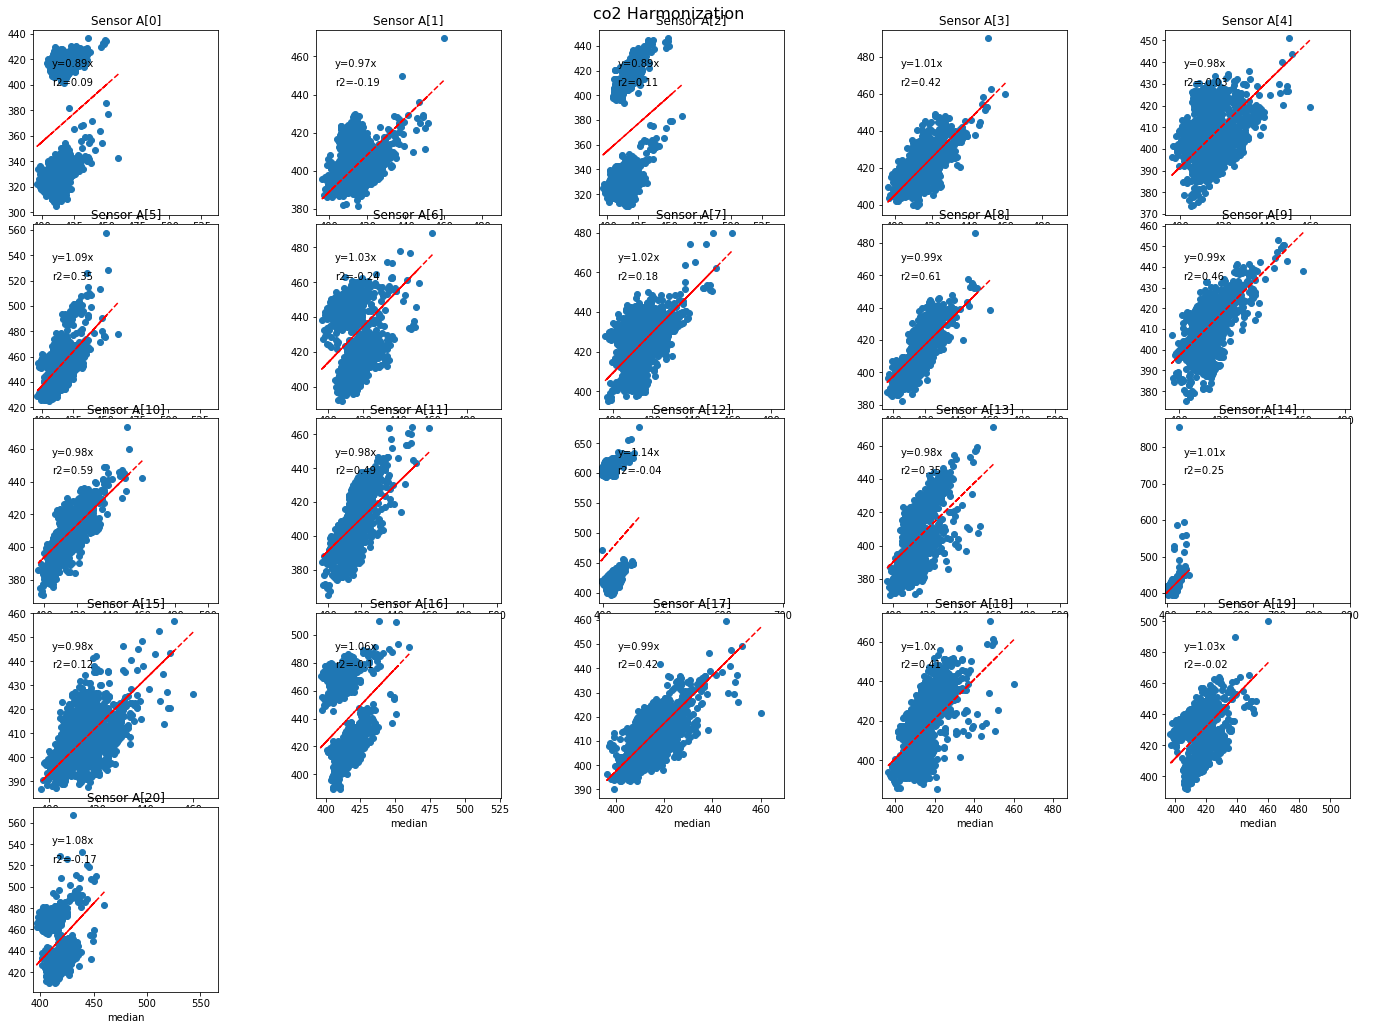

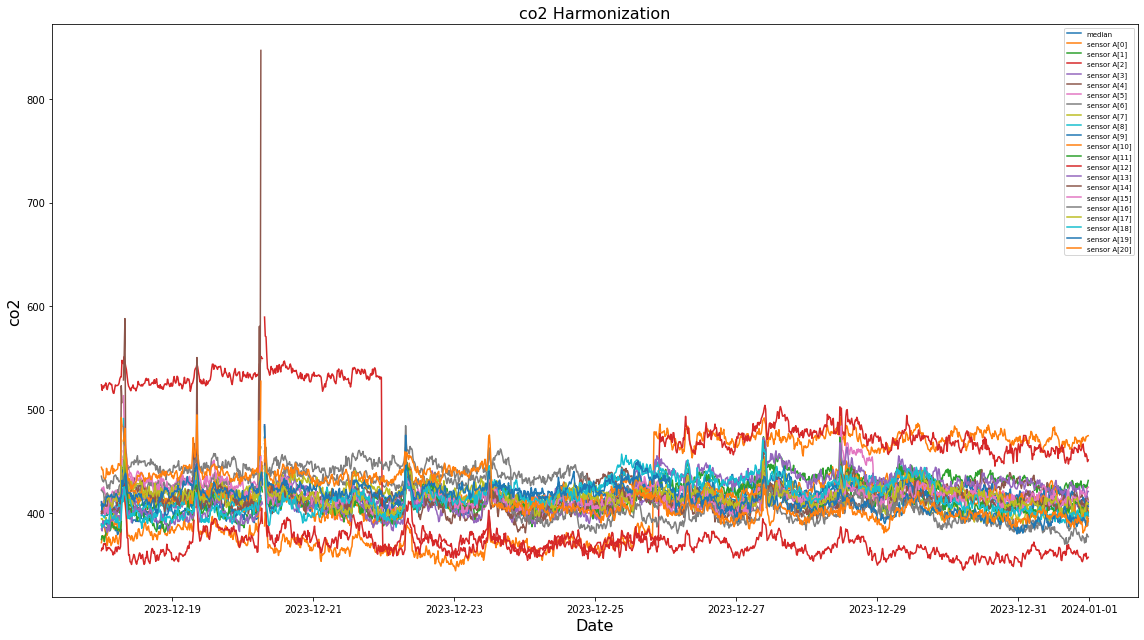

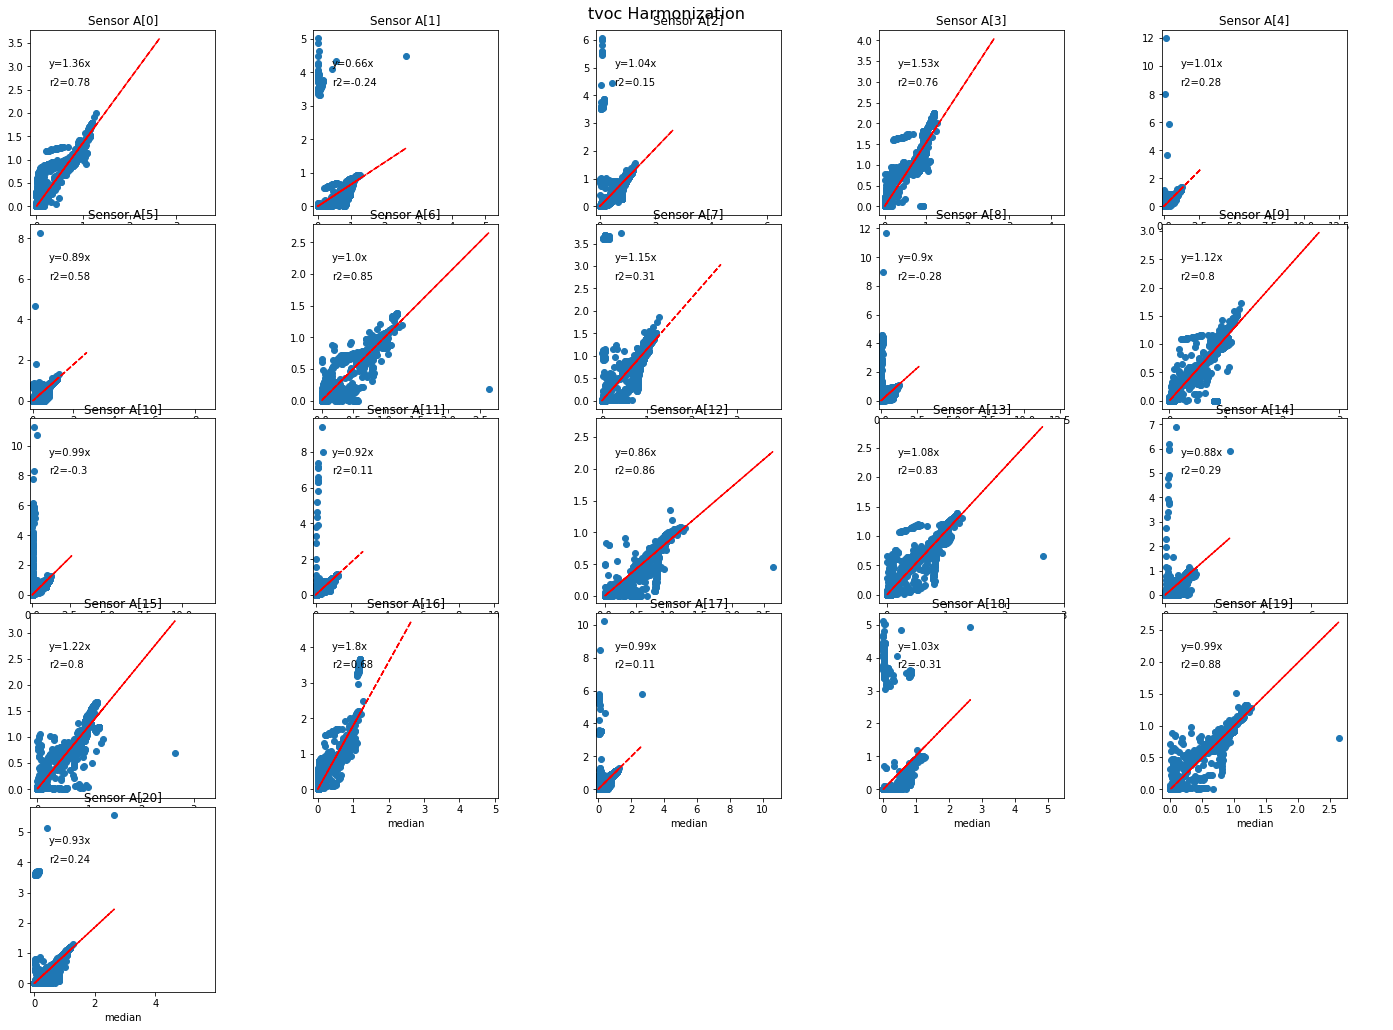

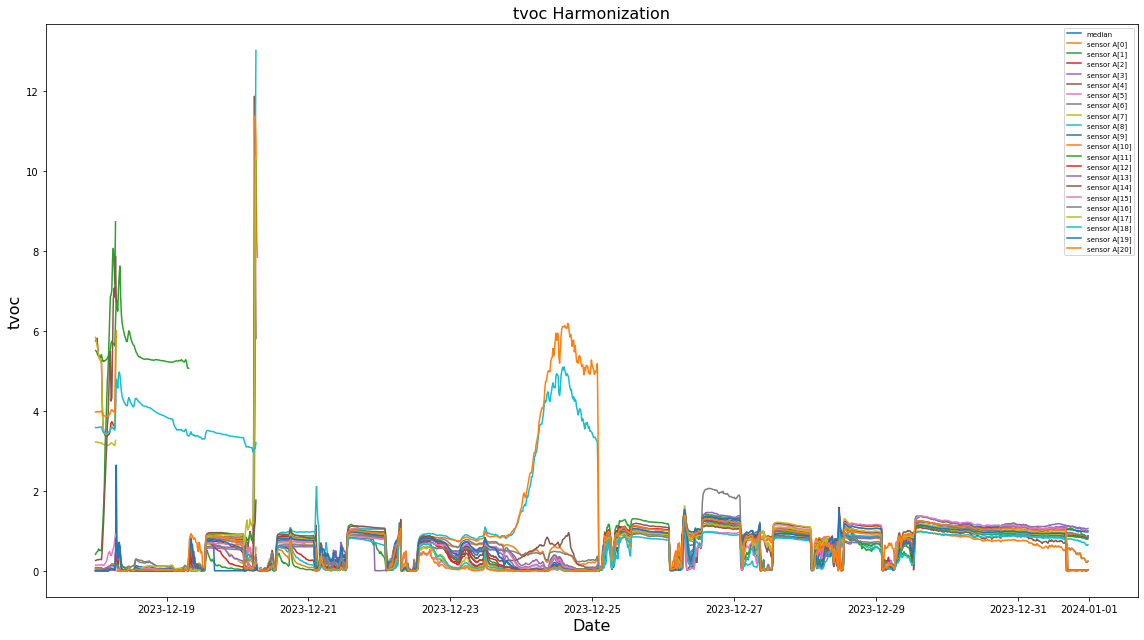

In [7]:
#get the data from harmonization
res_data = [harmonize(p) for p in parameters]

In [12]:
#get calibration factors and harmonized data
calibration_factors = [res_data[i][0] for i, _ in enumerate(parameters)]
r2_values = [res_data[i][2] for i, _ in enumerate(parameters)]
harmonized_data = [res_data[i][1] for i, _ in enumerate(parameters)]

#save the harmonized data in csv files, in level2_* folder
for i in range(n_sensors):
    sensor_harmonized_data = np.vstack([harmonized_data[j][i] for j, _ in enumerate(parameters)])
    sensor_harmonized_dataframe = pd.DataFrame(sensor_harmonized_data.T, columns=parameters)
    sensor_harmonized_dataframe.insert(0, time_header, dates)
    sensor_harmonized_dataframe.to_csv(f'{result_folder}/{level2_folder}/{sensor_names[i]}.csv', index=False)

#save the calibration factors in a csv file
#TODO: add r2 values
for i, parameter in enumerate(parameters):
    if i == 0:
        df_calibration_factors = pd.DataFrame(np.column_stack([calibration_factors[i], r2_values[i]]), columns=[f"{parameter} CF", f"{parameter} R2"])
        df_calibration_factors.insert(0, "sensor", sensor_names)
        df_calibration_factors.to_csv(f'{result_folder}/calibration_factors.csv', index=False)
    else:
        df_calibration_factors = pd.read_csv(f'{result_folder}/calibration_factors.csv')
        df_calibration_factors[f"{parameter} CF"] = calibration_factors[i]
        df_calibration_factors[f"{parameter} R2"] = r2_values[i]
        df_calibration_factors.to_csv(f'{result_folder}/calibration_factors.csv', index=False)


In [13]:
#metadata of the calibration factors
pm25_cf = calibration_factors[1]
cf_median, cf_mean, cf_min, cf_max = np.nanmedian(pm25_cf), np.mean(pm25_cf), np.min(pm25_cf), np.max(pm25_cf)
cf_10_perc, cf_90_perc = np.percentile(pm25_cf, 10), np.percentile(pm25_cf, 90)

print("for PM2.5 HF:")
print(f"median is:{cf_median}; mean is {cf_mean}")
print(f"min is:{cf_min}; max is {cf_max}")
print(f"10the percentile is {cf_10_perc}; 90the percentile is {cf_90_perc}")
#TODO
#for the universal code
#set protocol for the name of the csv files

for PM2.5 HF:
median is:0.99; mean is 1.0104761904761905
min is:0.77; max is 1.33
10the percentile is 0.85; 90the percentile is 1.14
